In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import logging
from time import time

In [12]:
training_logs = []

class TrainingLogger:
    def __init__(self, log_interval=10):
        self.log_interval = log_interval
        logging.basicConfig(level=logging.INFO, format='%(message)s')

    def on_epoch_begin(self, epoch):
        self.epoch_start_time = time()
        logging.info(f"Epoch {epoch + 1} starting.")

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time() - self.epoch_start_time
        logging.info(f"Epoch {epoch + 1} finished in {elapsed_time:.2f} seconds.")
        logs['epoch_time'] = elapsed_time  # Add epoch time to logs
        training_logs.append(logs)  # Collect training logs

    def on_batch_end(self, batch, logs=None):
        if (batch + 1) % self.log_interval == 0:
            logging.info(f"Batch {batch + 1}: Loss = {logs['loss']:.4f}, Accuracy = {logs['accuracy']:.4f}")


In [13]:
class RandomDataset(Dataset):
    def __init__(self, num_samples, num_features):
        self.num_samples = num_samples
        self.num_features = num_features
        self.data = torch.randn(num_samples, num_features)
        self.labels = torch.randint(0, 2, (num_samples,))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = RandomDataset(1000, 20)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [14]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_size, 2)

    def forward(self, x):
        return self.fc(x)

model = SimpleNN(20)

In [15]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs['loss']
        if self.best_loss is None or current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                logging.info("Early stopping triggered.")
                return True
        return False

In [16]:
def train_model(model, dataloader, criterion, optimizer, epochs, callback, early_stopping_callback=None):
    model.train()
    
    for epoch in range(epochs):
        callback.on_epoch_begin(epoch)
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
            callback.on_batch_end(batch_idx, logs={
                'loss': running_loss / (batch_idx + 1),
                'accuracy': correct_predictions / total_predictions
            })
        
        logs = {
            'loss': running_loss / len(dataloader),
            'accuracy': correct_predictions / total_predictions
        }
        callback.on_epoch_end(epoch, logs)
        
        if early_stopping_callback and early_stopping_callback.on_epoch_end(epoch, logs):
            break

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
callback = TrainingLogger(log_interval=10)
early_stopping_callback = EarlyStopping(patience=2)

train_model(model, dataloader, criterion, optimizer, epochs=5, callback=callback, early_stopping_callback=early_stopping_callback)

Epoch 1 starting.
Batch 10: Loss = 0.7636, Accuracy = 0.4688
Batch 20: Loss = 0.7596, Accuracy = 0.4750
Batch 30: Loss = 0.7543, Accuracy = 0.4833
Epoch 1 finished in 0.08 seconds.
Epoch 2 starting.
Batch 10: Loss = 0.7277, Accuracy = 0.5062
Batch 20: Loss = 0.7469, Accuracy = 0.4828
Batch 30: Loss = 0.7394, Accuracy = 0.4896
Epoch 2 finished in 0.06 seconds.
Epoch 3 starting.
Batch 10: Loss = 0.7269, Accuracy = 0.4938
Batch 20: Loss = 0.7267, Accuracy = 0.4891
Batch 30: Loss = 0.7274, Accuracy = 0.4885
Epoch 3 finished in 0.05 seconds.
Epoch 4 starting.
Batch 10: Loss = 0.7284, Accuracy = 0.4531
Batch 20: Loss = 0.7194, Accuracy = 0.4797
Batch 30: Loss = 0.7176, Accuracy = 0.4896
Epoch 4 finished in 0.05 seconds.
Epoch 5 starting.
Batch 10: Loss = 0.7091, Accuracy = 0.4969
Batch 20: Loss = 0.7074, Accuracy = 0.5047
Batch 30: Loss = 0.7108, Accuracy = 0.4969
Epoch 5 finished in 0.04 seconds.


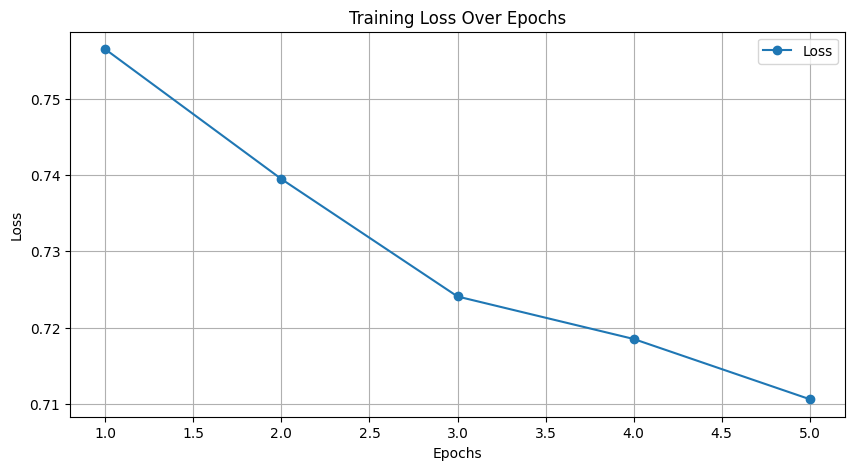

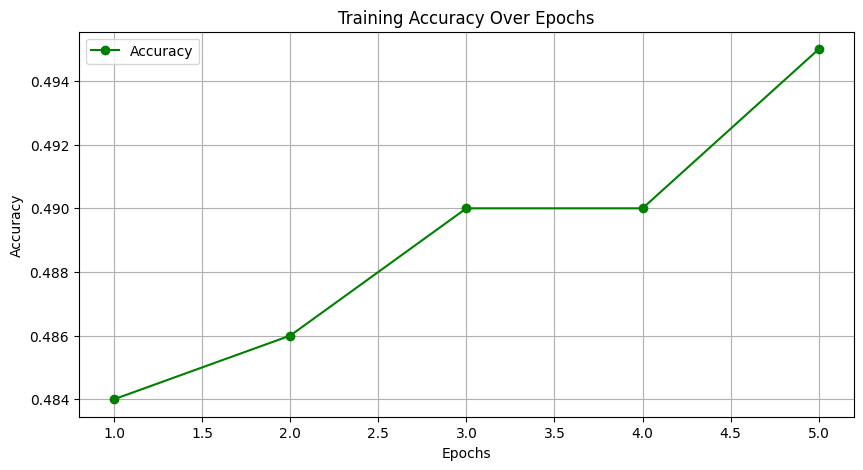

In [18]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values from logs
loss_values = [logs['loss'] for logs in training_logs]
accuracy_values = [logs['accuracy'] for logs in training_logs]
epochs = range(1, len(loss_values) + 1)

# Plot loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, label='Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_values, label='Accuracy', marker='o', color='green')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


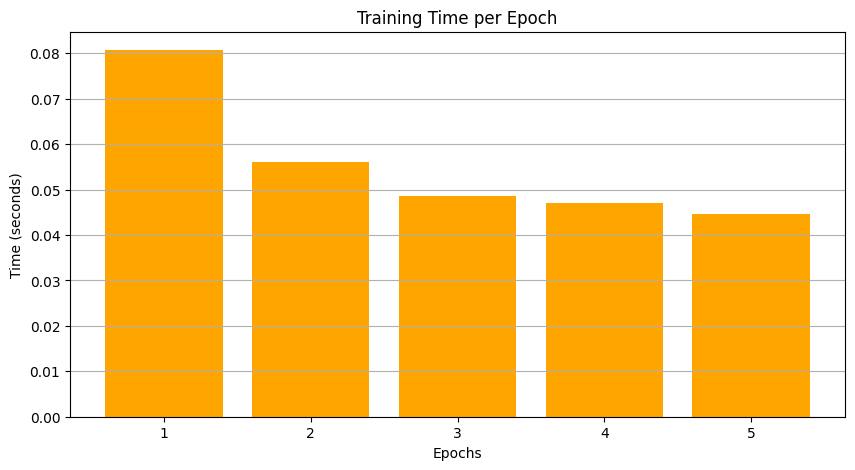

In [19]:
# Extract epoch times
epoch_times = [logs['epoch_time'] for logs in training_logs]

# Plot training time per epoch
plt.figure(figsize=(10, 5))
plt.bar(epochs, epoch_times, color='orange')
plt.title('Training Time per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.grid(axis='y')
plt.show()
